<a href="https://colab.research.google.com/github/Dyznef/BAITAPXULYANH/blob/master/XLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Link để capture ảnh trò chơi ở web: https://www.puzzle-nonograms.com/

Link ảnh mẫu để so sánh:

Colum: https://drive.google.com/drive/folders/1EVkMnwUWQFW0TU9m6Ie5OBJ6eokZLzLm?usp=drive_link

Row: https://drive.google.com/drive/folders/1K4DYh1A0wxwe6NqV1I1DD88ZoVfo9r_e?usp=drive_link

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import os

Grid dimensions: (147, 129)


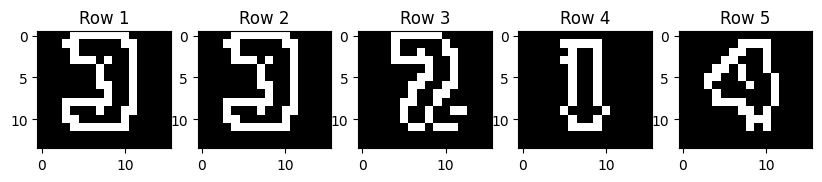

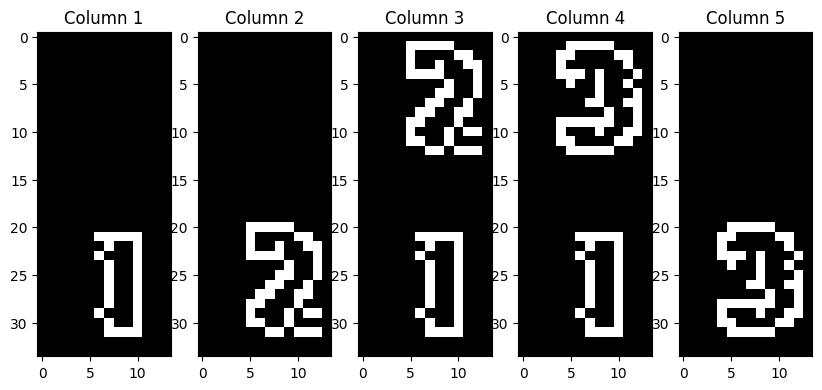

In [ ]:
# Define image path
image_path = '/content/drive/MyDrive/2_XLA/test1.png'

# Load and process the image
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(cv2.GaussianBlur(gray_image, (5, 5), 0), 50, 150)

# Find contours and get the largest one
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
x, y, w, h = cv2.boundingRect(approx_polygon)
grid = edges[y:y+h, x:x+w]

# Create and apply a mask
mask = np.ones_like(grid)
square_size = 103
mask[-square_size:, -square_size:] = 0
masked_image = cv2.bitwise_and(grid, grid, mask=mask)

# Print the dimensions of the grid
height, width = grid.shape[:2]
print(f'Grid dimensions: {grid.shape}')

# Define a list of crop sizes and coordinates
crop_sizes_and_coords = [((height, width), (max(0, height - square_size), max(0, width - square_size)))]

# Function to find the closest size in the size table
def find_closest_size(grid_size, size_table):
    closest_size = min(size_table, key=lambda size: abs(grid_size[0] - size[0][0]) + abs(grid_size[1] - size[0][1]))
    return closest_size

# Find the closest size and coordinates for the grid
closest_size, closest_coord = find_closest_size((height, width), crop_sizes_and_coords)

# Extract the four regions based on red lines
horizontal_line_y, vertical_line_x = closest_coord
top_left = grid[:horizontal_line_y, :vertical_line_x]
top_right = grid[:horizontal_line_y, vertical_line_x:]
bottom_left = grid[horizontal_line_y:, :vertical_line_x]
bottom_right = grid[horizontal_line_y:, vertical_line_x:]

# Function to split a region into cells
def split_into_cells(region, num_cells, axis=0):
    cell_size = region.shape[axis] // num_cells
    cells = [region[i*cell_size:(i+1)*cell_size] if axis == 0 else region[:, i*cell_size:(i+1)*cell_size] for i in range(num_cells)]
    return cells

# Function to crop margins from an image
def crop_margins(image, top, bottom, left, right):
    return image[top:image.shape[0]-bottom, left:image.shape[1]-right]

# Split regions into cells and display
num_rows, num_columns = 5, 5
row_cells = split_into_cells(bottom_left, num_rows, axis=0)
column_cells = split_into_cells(top_right, num_columns, axis=1)

def display_cells(cells, crop_values, num_cells, title):
    plt.figure(figsize=(10, 5))
    for i, cell in enumerate(cells):
        cropped_cell = crop_margins(cell, *crop_values)
        plt.subplot(1, num_cells, i+1)
        plt.imshow(cropped_cell, cmap='gray')
        plt.title(f'{title} {i+1}')
    plt.show()

display_cells(row_cells, (4, 2, 6, 4), num_rows, 'Row')
display_cells(column_cells, (6, 4, 3, 3), num_columns, 'Column')

Row values: [[3], [3], [2], [1], [4]]
Column values: [[1], [2], [2, 1], [3, 1], [3]]


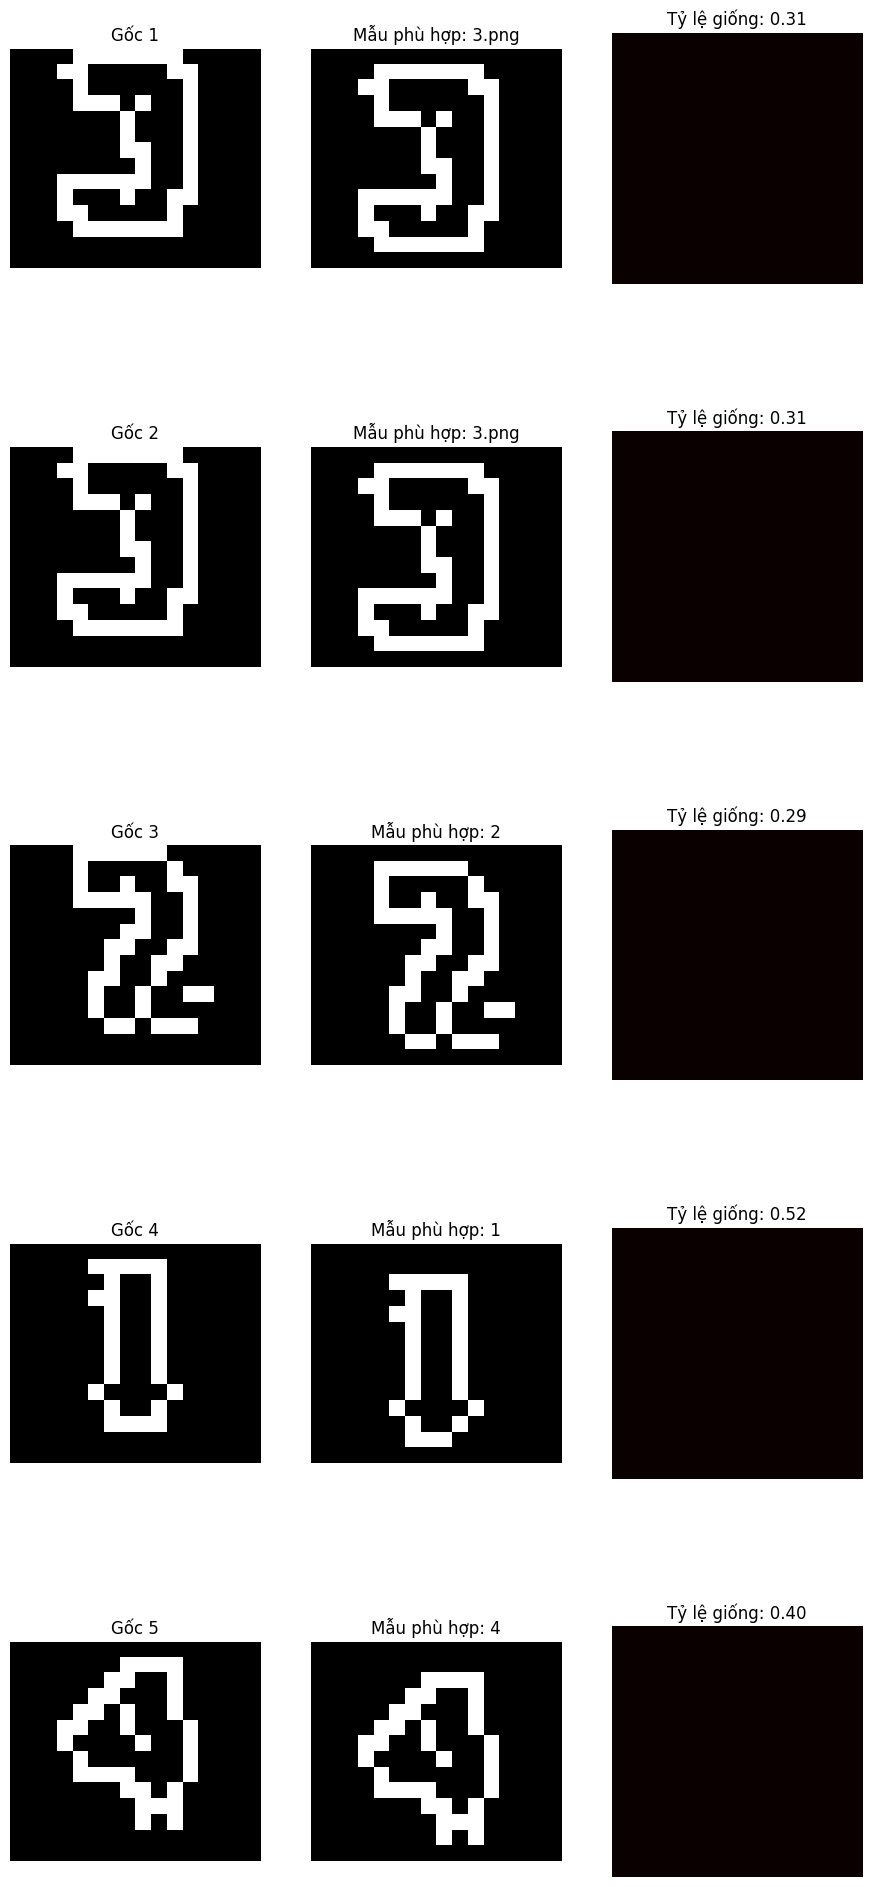

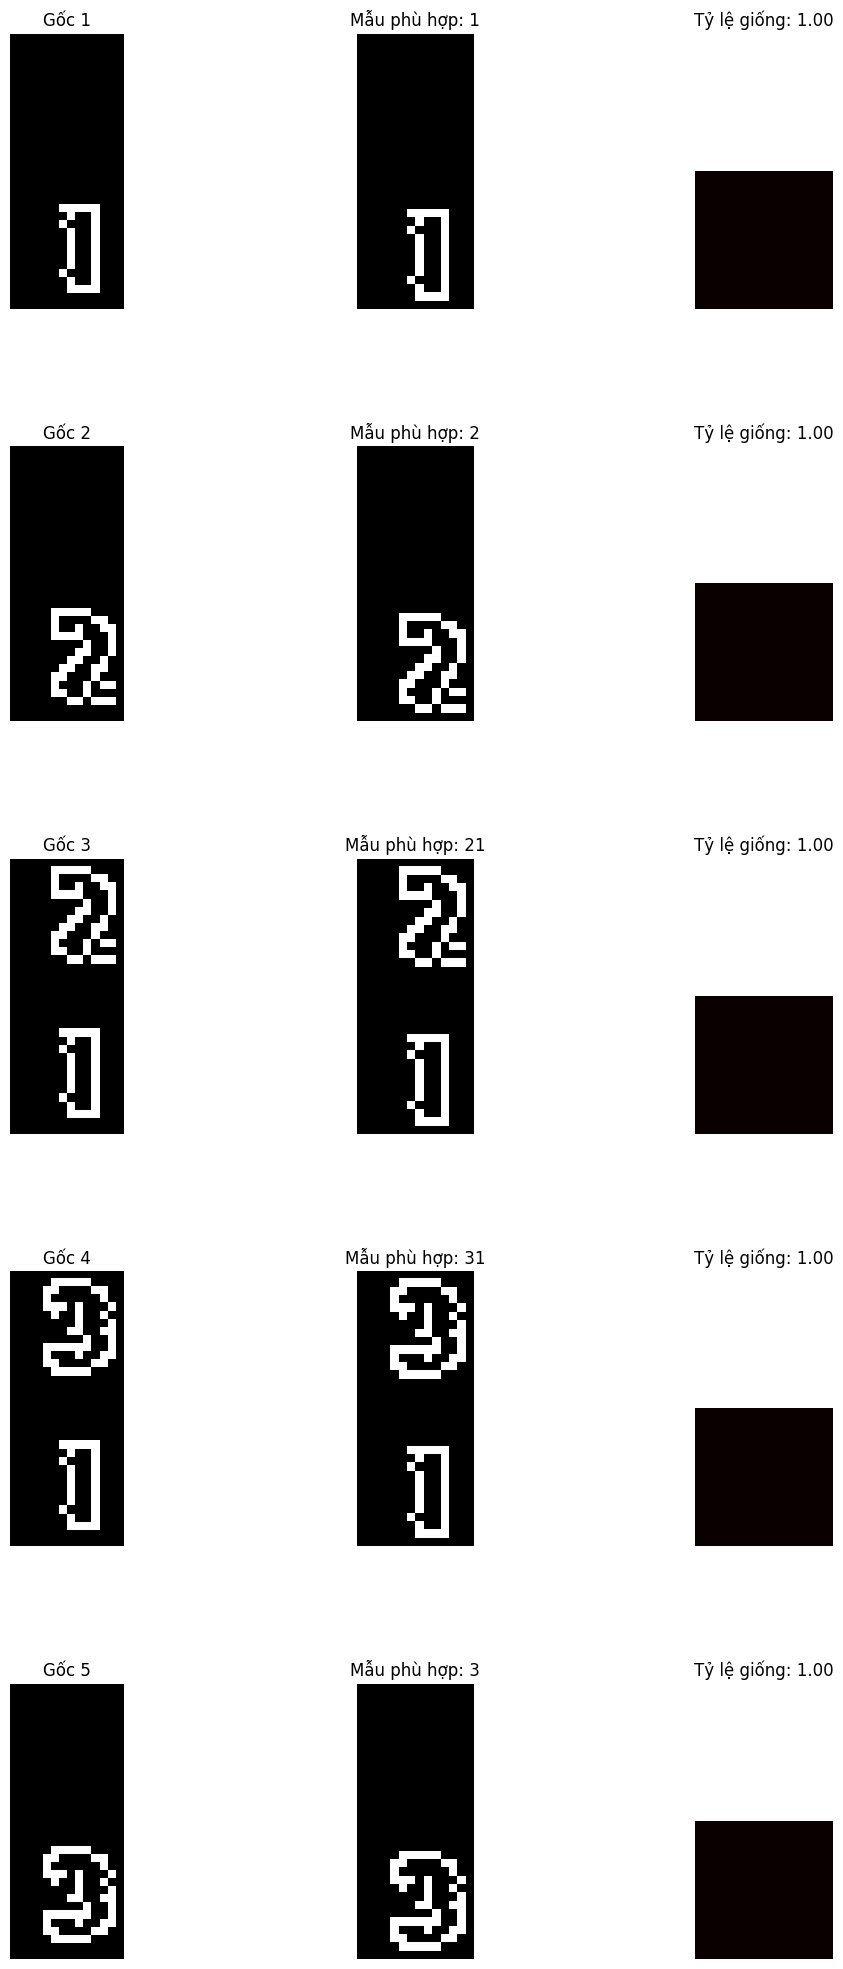

In [ ]:
# Define the path to the sample images directories
column_sample_dir = '/content/drive/MyDrive/2_XLA/Column_samples'
row_sample_dir = '/content/drive/MyDrive/2_XLA/Row_samples'

# Function to perform template matching and find the best match
def find_best_template_match(cell_image, sample_dir, size_threshold=10):
    best_match_score, best_value, best_match_image = -1, None, None

    for sample_filename in os.listdir(sample_dir):
        sample_path = os.path.join(sample_dir, sample_filename)
        sample_image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

        if sample_image.shape[0] > cell_image.shape[0] or sample_image.shape[1] > cell_image.shape[1]:
            continue

        size_diff = abs(cell_image.shape[0] - sample_image.shape[0]) + abs(cell_image.shape[1] - sample_image.shape[1])
        if size_diff > size_threshold:
            continue

        res = cv2.matchTemplate(cell_image, sample_image, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)

        if max_val > best_match_score:
            best_match_score = max_val
            best_value = sample_filename.split(' ')[0]
            best_match_image = sample_image

    return best_value, best_match_image, best_match_score

# Function to split concatenated values into lists of integers
def parse_concatenated_values(value):
    return [int(char) for char in value if char.isdigit()]

# Define a function to crop image margins
def crop_margins(image, top, bottom, left, right):
    return image[top:-bottom, left:-right]

# Initialize the lists to store the column and row values
col_values, row_values = [], []

# Create figures to display the comparisons
fig_row, axes_row = plt.subplots(nrows=len(row_cells), ncols=3, figsize=(11, len(row_cells) * 5))
fig_col, axes_col = plt.subplots(nrows=len(column_cells), ncols=3, figsize=(12, len(column_cells) * 5))

def process_cells(cells, sample_dir, crop_margins_values, axes, values_list):
    for i, cell in enumerate(cells):
        cropped_cell = crop_margins(cell, *crop_margins_values)
        best_match_value, best_match_image, best_match_score = find_best_template_match(cropped_cell, sample_dir)
        if best_match_value:
            values_list.append(parse_concatenated_values(best_match_value))

        axes[i, 0].imshow(cropped_cell, cmap='gray')
        axes[i, 0].set_title(f'Gốc {i+1}')
        axes[i, 0].axis('off')

        if best_match_image is not None:
            axes[i, 1].imshow(best_match_image, cmap='gray')
            axes[i, 1].set_title(f'Mẫu phù hợp: {best_match_value}')
            axes[i, 1].axis('off')

            res = cv2.matchTemplate(cropped_cell, best_match_image, cv2.TM_CCOEFF_NORMED)
            axes[i, 2].imshow(res, cmap='hot')
            axes[i, 2].set_title(f'Tỷ lệ giống: {round(best_match_score*100):.2f}%')
            axes[i, 2].axis('off')
        else:
            axes[i, 1].set_title('Không mẫu nào giống!')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')

process_cells(row_cells, row_sample_dir, (4, 2, 6, 4), axes_row, row_values)
process_cells(column_cells, column_sample_dir, (6, 4, 3, 3), axes_col, col_values)

# Display the row and column values
print("Row values:", row_values)
print("Column values:", col_values)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


In [ ]:
def find_options(length, filled, pattern='', empty=''):
    total_empty = length - sum(filled) - len(filled) + 1
    lines = []

    for pad in range(total_empty + 1):
        line = '0' * pad + '1' * filled[0]
        if len(filled) > 1:
            subs = find_options(length - len(line) - 1, filled[1:])
            lines.extend([line + '0' + sub for sub in subs])
        else:
            lines.append(line + '0' * (length - len(line)))

    if pattern:
        mask = int(pattern, 2)
        lines = [line for line in lines if (int(line, 2) & mask) == mask]
    if empty:
        mask = int(empty, 2)
        lines = [line for line in lines if not (int(line, 2) & mask)]

    return lines

def find_overlap(length, patterns):
    if not patterns:
        return '0' * length
    overlap = int(patterns[0], 2)
    for pattern in patterns[1:]:
        overlap &= int(pattern, 2)
    return f'{overlap:0{length}b}'

def find_empty(length, potential):
    patterns = [''.join('1' if bit == '0' else '0' for bit in pattern) for pattern in potential]
    return find_overlap(length, patterns)

def update_existing(col_existing, row_existing):
    for r_idx, row in enumerate(row_existing):
        for c_idx, cell in enumerate(row):
            if cell == '1':
                col_existing[c_idx] = col_existing[c_idx][:r_idx] + '1' + col_existing[c_idx][r_idx+1:]
            if col_existing[c_idx][r_idx] == '1':
                row_existing[r_idx] = row_existing[r_idx][:c_idx] + '1' + row_existing[r_idx][c_idx+1:]
    return row_existing, col_existing

def solve(length, horizontal_grid, vertical_grid, max_passes=0):
    def process_grid(grid, existing, empty):
        for idx, constraints in enumerate(grid):
            patterns = find_options(length, constraints, existing[idx], empty[idx])
            if not patterns:
                print(f"No patterns found for index {idx} with constraints {constraints}")
            existing[idx] = find_overlap(length, patterns)
            empty[idx] = find_empty(length, patterns)

    horizontal_existing = ['0' * length] * len(horizontal_grid)
    vertical_existing = ['0' * length] * len(vertical_grid)
    horizontal_empty = ['0' * length] * len(horizontal_grid)
    vertical_empty = ['0' * length] * len(vertical_grid)

    process_grid(horizontal_grid, horizontal_existing, horizontal_empty)
    process_grid(vertical_grid, vertical_existing, vertical_empty)

    passes = 0
    done = False

    while not done:
        horiz_backup, vert_backup = horizontal_existing[:], vertical_existing[:]

        vertical_existing, horizontal_existing = update_existing(horizontal_existing, vertical_existing)
        vertical_empty, horizontal_empty = update_existing(horizontal_empty, vertical_empty)

        process_grid(horizontal_grid, horizontal_existing, horizontal_empty)
        process_grid(vertical_grid, vertical_existing, vertical_empty)

        if horizontal_existing == horiz_backup and vertical_existing == vert_backup:
            done = True
        passes += 1

        if max_passes and passes >= max_passes:
            done = True

    return horizontal_existing, horizontal_empty, passes

def print_nonogram(horizontal_grid, vertical_grid, solved):
    max_row_label_width = max(len(str(row)) for row in horizontal_grid)
    col_labels = [" " * max_row_label_width] + [str(col).center(5) for col in vertical_grid]
    print(" " * (max_row_label_width + 2) + " ".join(col_labels))

    for row_label, row in zip(horizontal_grid, solved):
        print(str(row_label).rjust(max_row_label_width) + "  " + "  ".join(row))

length = 5
horizontal_grid = row_values
vertical_grid = col_values

solved, empty, passes = solve(length, horizontal_grid, vertical_grid)

solved = [['1' if char == '1' else '0' for char in line] for line in solved]

print("Nonogram Solution:")
print_nonogram(horizontal_grid, vertical_grid, solved)


Nonogram Solution:
          [1]   [2]  [2, 1] [3, 1]  [3] 
[3]  0  0  1  1  1
[3]  0  0  1  1  1
[2]  0  0  0  1  1
[1]  0  1  0  0  0
[4]  1  1  1  1  0


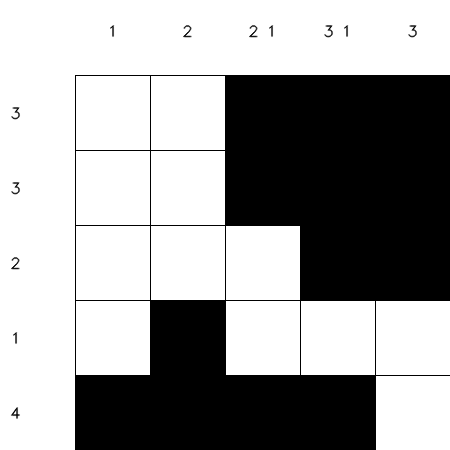

In [ ]:
def draw_nonogram(horizontal_grid, vertical_grid, solved):
    cell_size = 75 #Kích thước các ô 5x5
    margin = 75  # Kích thước lề
    grid_height = len(horizontal_grid)
    grid_width = len(vertical_grid)

    # Calculate the size of the image
    img_height = cell_size * grid_height + margin
    img_width = cell_size * grid_width + margin

    # Create a white image
    img = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255

    # Draw the grid cells
    for i in range(grid_height):
        for j in range(grid_width):
            x = margin + j * cell_size
            y = margin + i * cell_size

            if solved[i][j] == '1':
                cv2.rectangle(img, (x, y), (x + cell_size, y + cell_size), (0, 0, 0), -1)
            else:
                cv2.rectangle(img, (x, y), (x + cell_size, y + cell_size), (255, 255, 255), -1)
            cv2.rectangle(img, (x, y), (x + cell_size, y + cell_size), (0, 0, 0), 1)

    # Draw the horizontal labels
    for i, row in enumerate(horizontal_grid):
        text = ' '.join(map(str, row))
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = 10
        text_y = margin + i * cell_size + (cell_size + text_size[1]) // 2
        cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Draw the vertical labels
    for j, col in enumerate(vertical_grid):
        text = ' '.join(map(str, col))
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = margin + j * cell_size + (cell_size - text_size[0]) // 2
        text_y = 30 + text_size[1] // 2
        cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    return img

img = draw_nonogram(horizontal_grid, vertical_grid, solved)
cv2_imshow(img)


# **TEST LẠI CÁC CHỨC NĂNG**

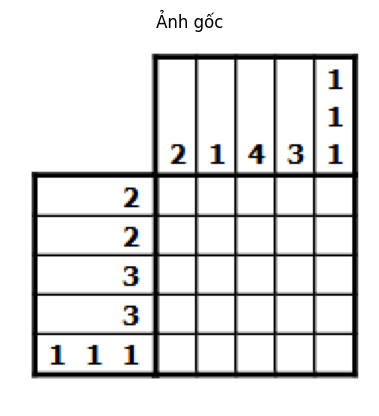

In [ ]:
# Đọc ảnh gốc
image_path = '/content/drive/MyDrive/2_XLA/test4.png'
image = cv2.imread(image_path)

# Hiển thị ảnh gốc
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Ảnh gốc')
plt.axis('off')
plt.show()

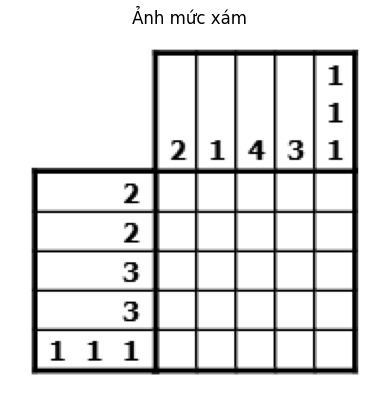

In [ ]:
  # Chuyển ảnh sang mức xám
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Hiển thị ảnh mức xám
plt.imshow(gray_image, cmap='gray')
plt.title('Ảnh mức xám')
plt.axis('off')
plt.show()


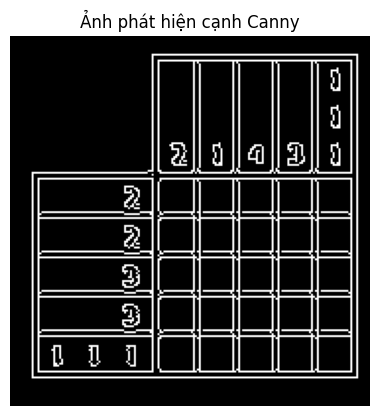

In [ ]:
# Áp dụng Gaussian Blur
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Phát hiện cạnh Canny
edges = cv2.Canny(blurred_image, 50, 150)

# Hiển thị ảnh phát hiện cạnh
plt.imshow(edges, cmap='gray')
plt.title('Ảnh phát hiện cạnh Canny')
plt.axis('off')
plt.show()

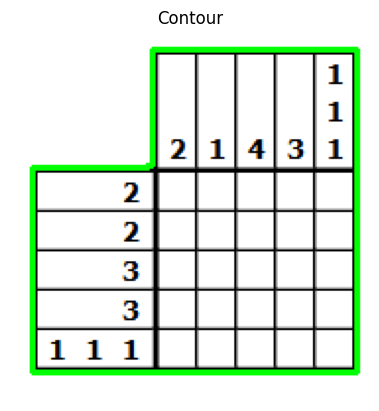

In [ ]:
# Tìm contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lấy contour lớn nhất theo diện tích
largest_contour = max(contours, key=cv2.contourArea)

# Vẽ contour lớn nhất lên ảnh gốc để hiển thị
contour_image = image.copy()
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

# Hiển thị ảnh với contour lớn nhất
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contour')
plt.axis('off')
plt.show()

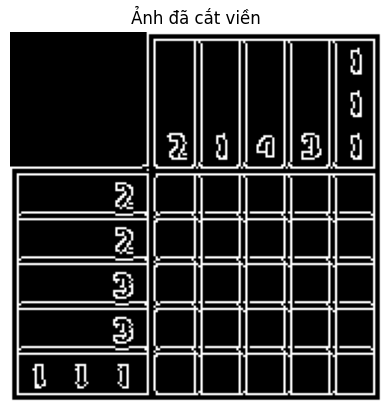

In [ ]:
# Lấy hình chữ nhật bao quanh contour lớn nhất
x, y, w, h = cv2.boundingRect(largest_contour)
grid = edges[y:y+h, x:x+w]


plt.imshow(grid, cmap='gray')
plt.title('Ảnh đã cắt viền')
plt.axis('off')
plt.show()

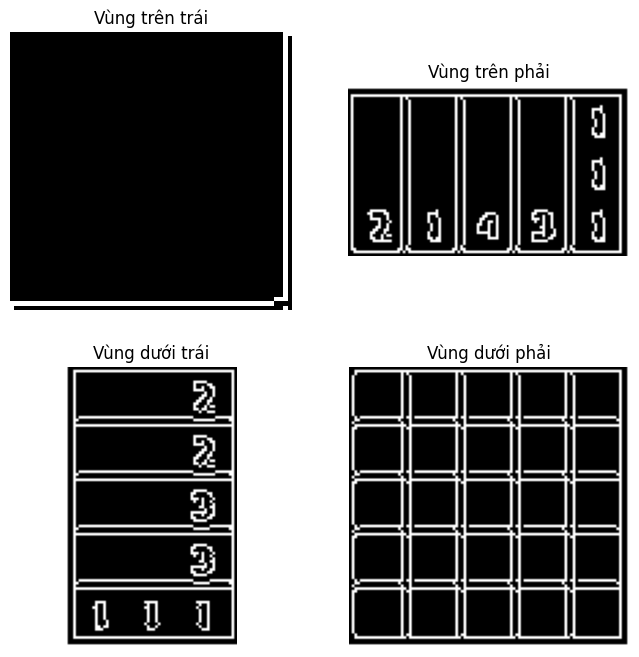

In [ ]:
# Chia lưới thành các vùng
square_size = 103
horizontal_line_y = max(0, grid.shape[0] - square_size)
vertical_line_x = max(0, grid.shape[1] - square_size)

top_left = grid[:horizontal_line_y, :vertical_line_x]
top_right = grid[:horizontal_line_y, vertical_line_x:]
bottom_left = grid[horizontal_line_y:, :vertical_line_x]
bottom_right = grid[horizontal_line_y:, vertical_line_x:]

# Tạo figure để hiển thị các vùng theo thứ tự
plt.figure(figsize=(8, 8))

# Hiển thị vùng trên trái
plt.subplot(2, 2, 1)
plt.imshow(top_left, cmap='gray')
plt.title('Vùng trên trái')
plt.axis('off')

# Hiển thị vùng trên phải
plt.subplot(2, 2, 2)
plt.imshow(top_right, cmap='gray')
plt.title('Vùng trên phải')
plt.axis('off')

# Hiển thị vùng dưới trái
plt.subplot(2, 2, 3)
plt.imshow(bottom_left, cmap='gray')
plt.title('Vùng dưới trái')
plt.axis('off')

# Hiển thị vùng dưới phải
plt.subplot(2, 2, 4)
plt.imshow(bottom_right, cmap='gray')
plt.title('Vùng dưới phải')
plt.axis('off')

# Hiển thị toàn bộ figure
plt.show()

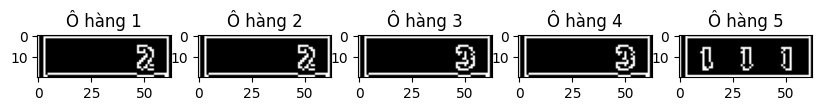

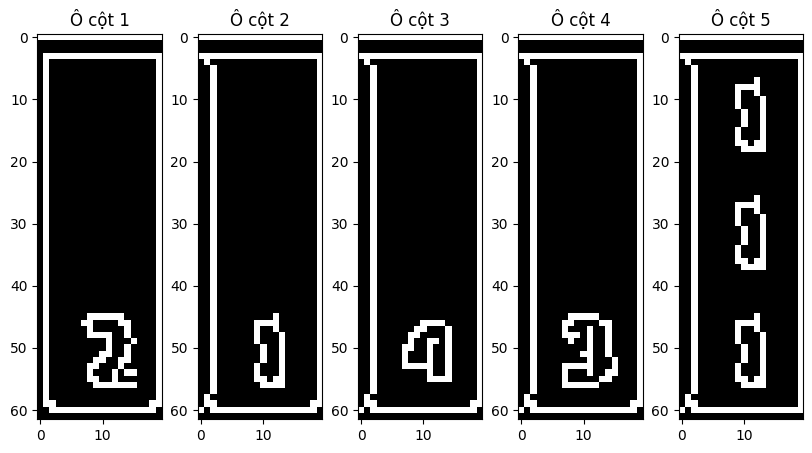

In [ ]:
# Định nghĩa hàm chia vùng thành các ô
def split_into_cells(region, num_cells, axis=0):
    cell_size = region.shape[axis] // num_cells
    cells = [region[i*cell_size:(i+1)*cell_size] if axis == 0 else region[:, i*cell_size:(i+1)*cell_size] for i in range(num_cells)]
    return cells

# Chia vùng dưới trái và trên phải thành các ô
num_rows, num_columns = 5, 5
row_cells = split_into_cells(bottom_left, num_rows, axis=0)
column_cells = split_into_cells(top_right, num_columns, axis=1)

# Hiển thị các ô của vùng dưới trái
plt.figure(figsize=(10, 5))
for i, cell in enumerate(row_cells):
    plt.subplot(1, num_rows, i+1)
    plt.imshow(cell, cmap='gray')
    plt.title(f'Ô hàng {i+1}')
plt.show()

# Hiển thị các ô của vùng trên phải
plt.figure(figsize=(10, 5))
for i, cell in enumerate(column_cells):
    plt.subplot(1, num_columns, i+1)
    plt.imshow(cell, cmap='gray')
    plt.title(f'Ô cột {i+1}')
plt.show()


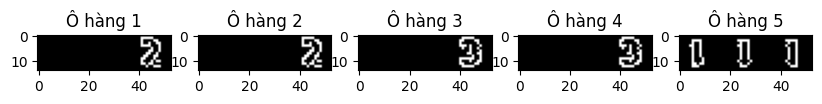

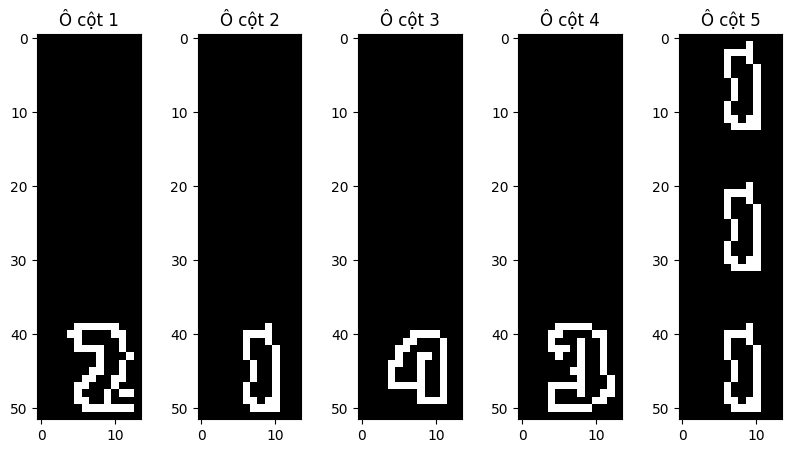

In [ ]:
# Function to crop margins from an image
def crop_margins(image, top, bottom, left, right):
    return image[top:image.shape[0]-bottom, left:image.shape[1]-right]

# Split regions into cells and display
num_rows, num_columns = 5, 5
row_cells = split_into_cells(bottom_left, num_rows, axis=0)
column_cells = split_into_cells(top_right, num_columns, axis=1)

def display_cells(cells, crop_values, num_cells, title):
    plt.figure(figsize=(10, 5))
    for i, cell in enumerate(cells):
        cropped_cell = crop_margins(cell, *crop_values)
        plt.subplot(1, num_cells, i+1)
        plt.imshow(cropped_cell, cmap='gray')
        plt.title(f'{title} {i+1}')
    plt.show()

display_cells(row_cells, (4, 2, 6, 4), num_rows, 'Ô hàng')
display_cells(column_cells, (6, 4, 3, 3), num_columns, 'Ô cột')

Giá trị của hàng: [[2], [2], [3], [3], [1, 1, 1]]
Giá trị của cột: [[2], [1], [4], [3], [1, 1, 1]]


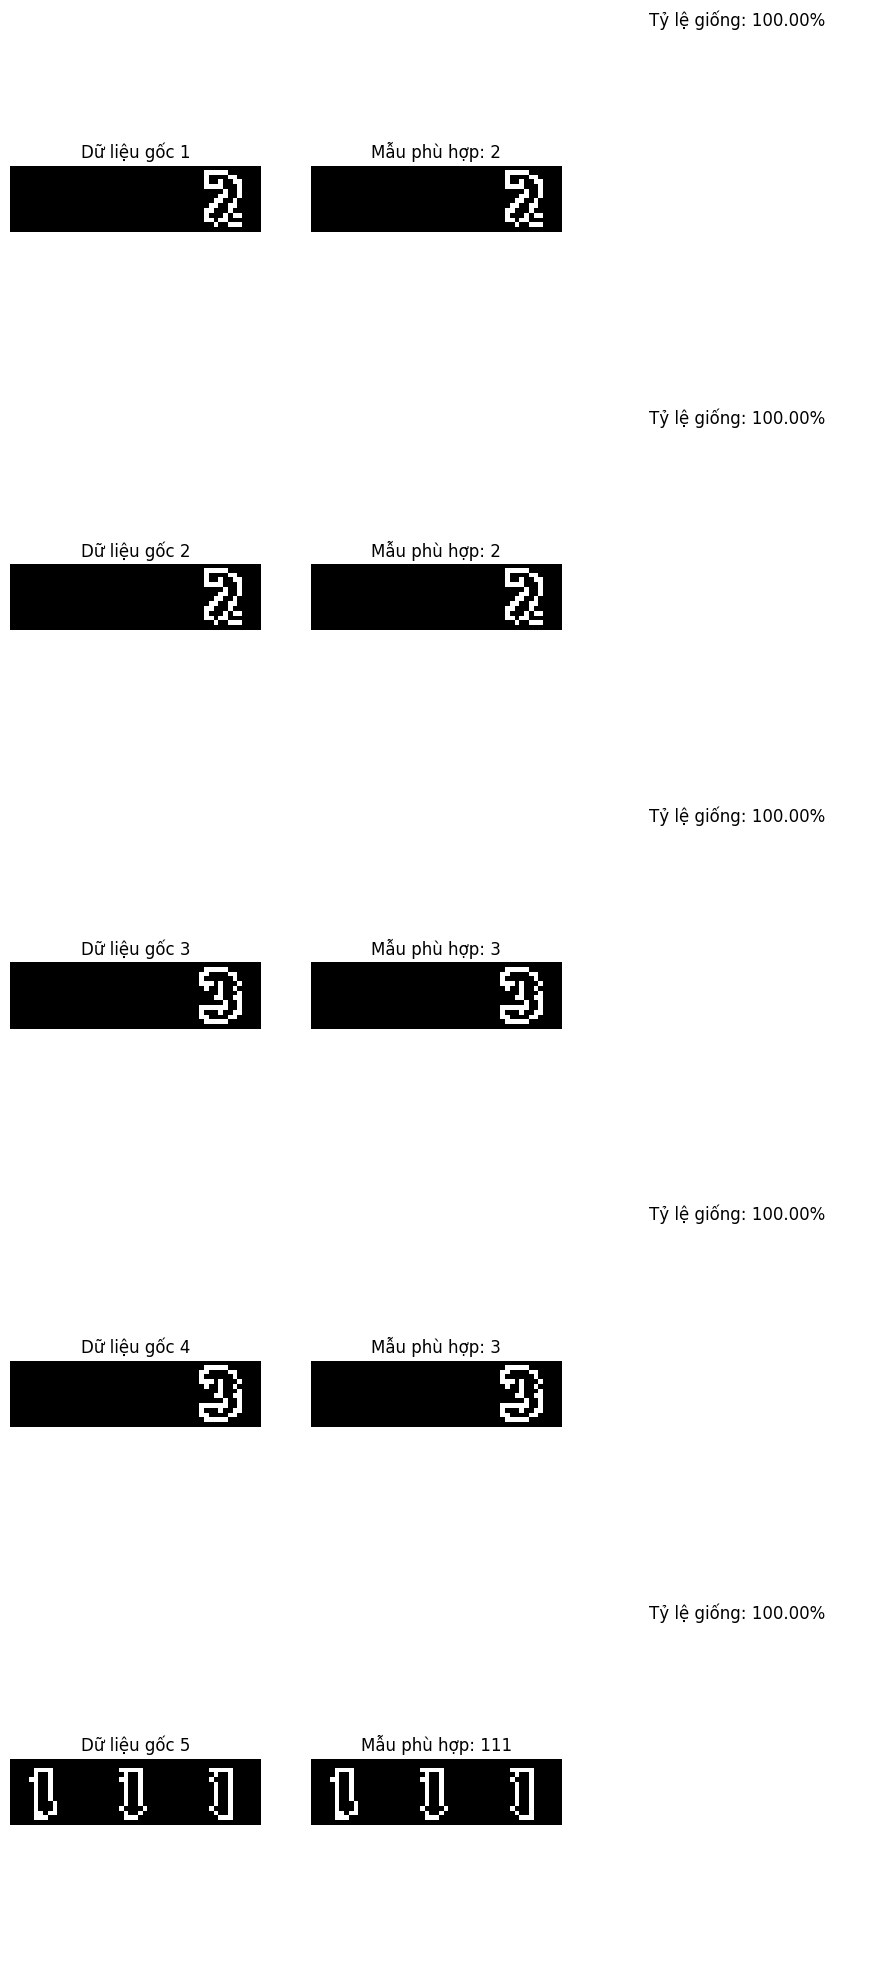

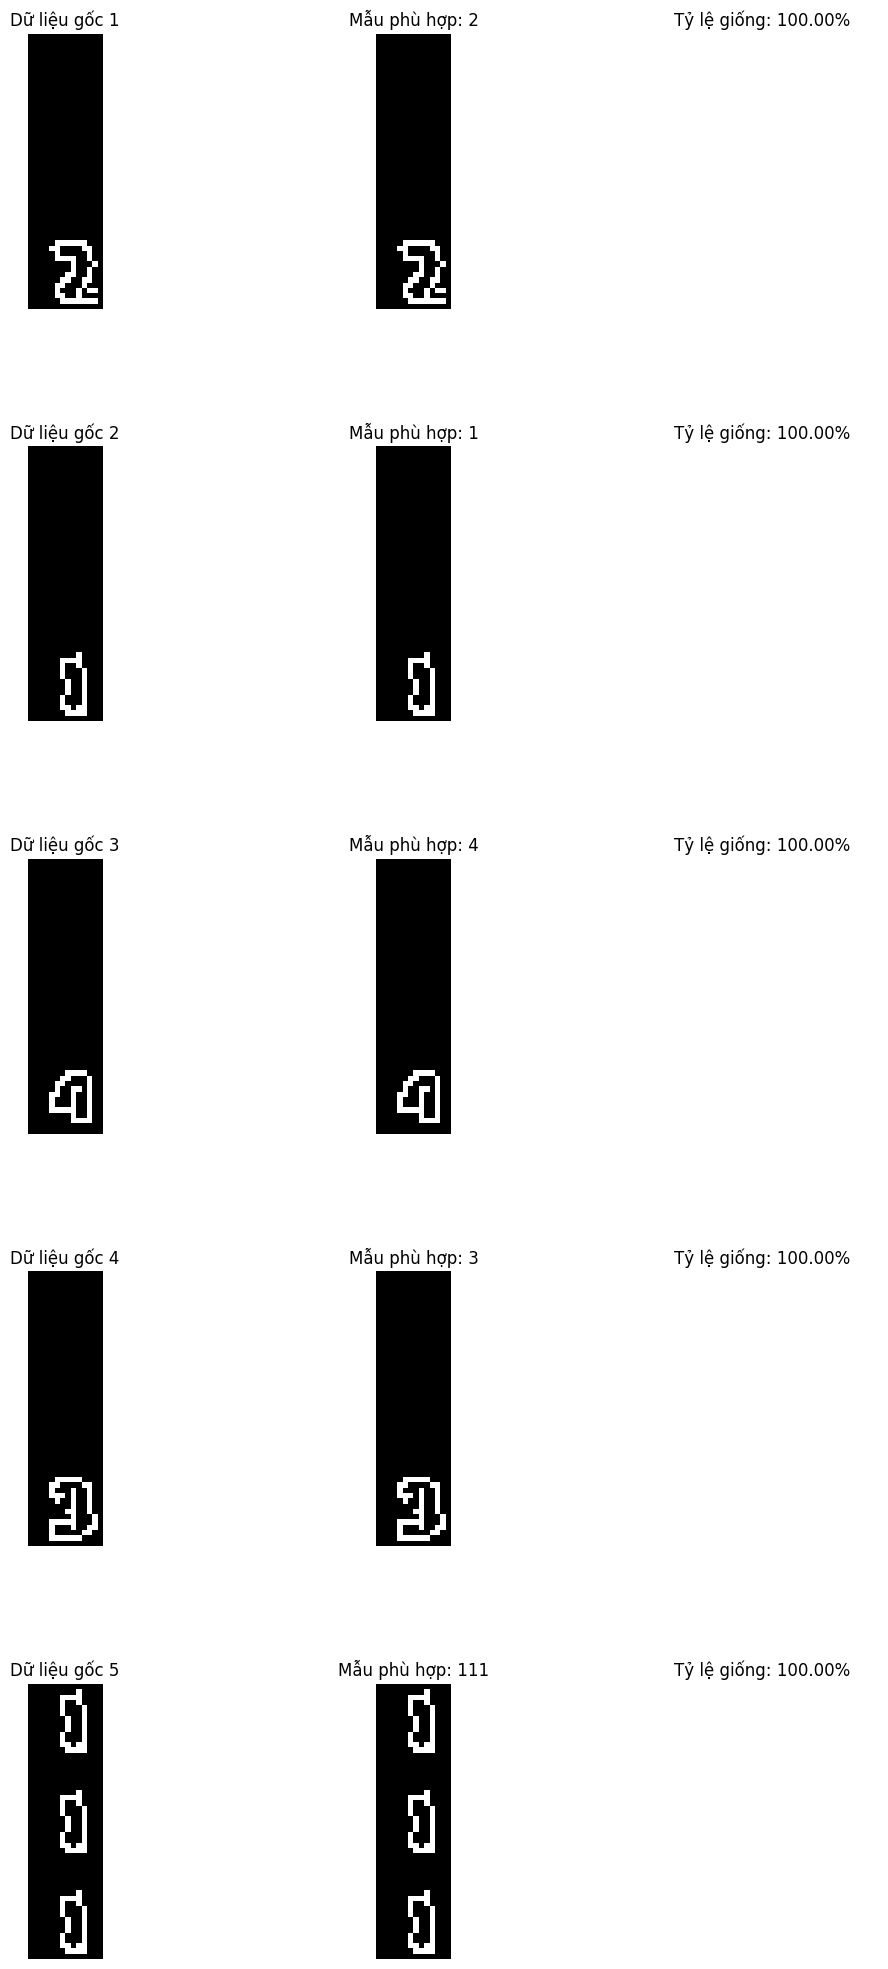

In [ ]:
# Define the path to the sample images directories
column_sample_dir = '/content/drive/MyDrive/2_XLA/Column_samples'
row_sample_dir = '/content/drive/MyDrive/2_XLA/Row_samples'

# Function to perform template matching and find the best match
def find_best_template_match(cell_image, sample_dir, size_threshold=10):
    best_match_score, best_value, best_match_image = -1, None, None

    for sample_filename in os.listdir(sample_dir):
        sample_path = os.path.join(sample_dir, sample_filename)
        sample_image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

        if sample_image.shape[0] > cell_image.shape[0] or sample_image.shape[1] > cell_image.shape[1]:
            continue

        size_diff = abs(cell_image.shape[0] - sample_image.shape[0]) + abs(cell_image.shape[1] - sample_image.shape[1])
        if size_diff > size_threshold:
            continue

        res = cv2.matchTemplate(cell_image, sample_image, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)

        if max_val > best_match_score:
            best_match_score = max_val
            best_value = sample_filename.split(' ')[0]
            best_match_image = sample_image

    return best_value, best_match_image, best_match_score

# Function to split concatenated values into lists of integers
def parse_concatenated_values(value):
    return [int(char) for char in value if char.isdigit()]

# Define a function to crop image margins
def crop_margins(image, top, bottom, left, right):
    return image[top:-bottom, left:-right]

# Initialize the lists to store the column and row values
col_values, row_values = [], []

# Create figures to display the comparisons
fig_row, axes_row = plt.subplots(nrows=len(row_cells), ncols=3, figsize=(11, len(row_cells) * 5))
fig_col, axes_col = plt.subplots(nrows=len(column_cells), ncols=3, figsize=(12, len(column_cells) * 5))

def process_cells(cells, sample_dir, crop_margins_values, axes, values_list):
    for i, cell in enumerate(cells):
        cropped_cell = crop_margins(cell, *crop_margins_values)
        best_match_value, best_match_image, best_match_score = find_best_template_match(cropped_cell, sample_dir)
        if best_match_value:
            values_list.append(parse_concatenated_values(best_match_value))

        axes[i, 0].imshow(cropped_cell, cmap='gray')
        axes[i, 0].set_title(f'Dữ liệu gốc {i+1}')
        axes[i, 0].axis('off')

        if best_match_image is not None:
            axes[i, 1].imshow(best_match_image, cmap='gray')
            axes[i, 1].set_title(f'Mẫu phù hợp: {best_match_value}')
            axes[i, 1].axis('off')

            res = cv2.matchTemplate(cropped_cell, best_match_image, cv2.TM_CCOEFF_NORMED)
            axes[i, 2].set_title(f'Tỷ lệ giống: {round(best_match_score*100):.2f}%')
            axes[i, 2].axis('off')
        else:
            axes[i, 1].set_title('Không mẫu nào giống!')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')

process_cells(row_cells, row_sample_dir, (4, 2, 6, 4), axes_row, row_values)
process_cells(column_cells, column_sample_dir, (6, 4, 3, 3), axes_col, col_values)

# Display the row and column values
print("Giá trị của hàng:", row_values)
print("Giá trị của cột:", col_values)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


Row values: [[3], [3], [4], [1], [4]]
Column values: [[2], [3], [2, 1], [2, 1], [3]]


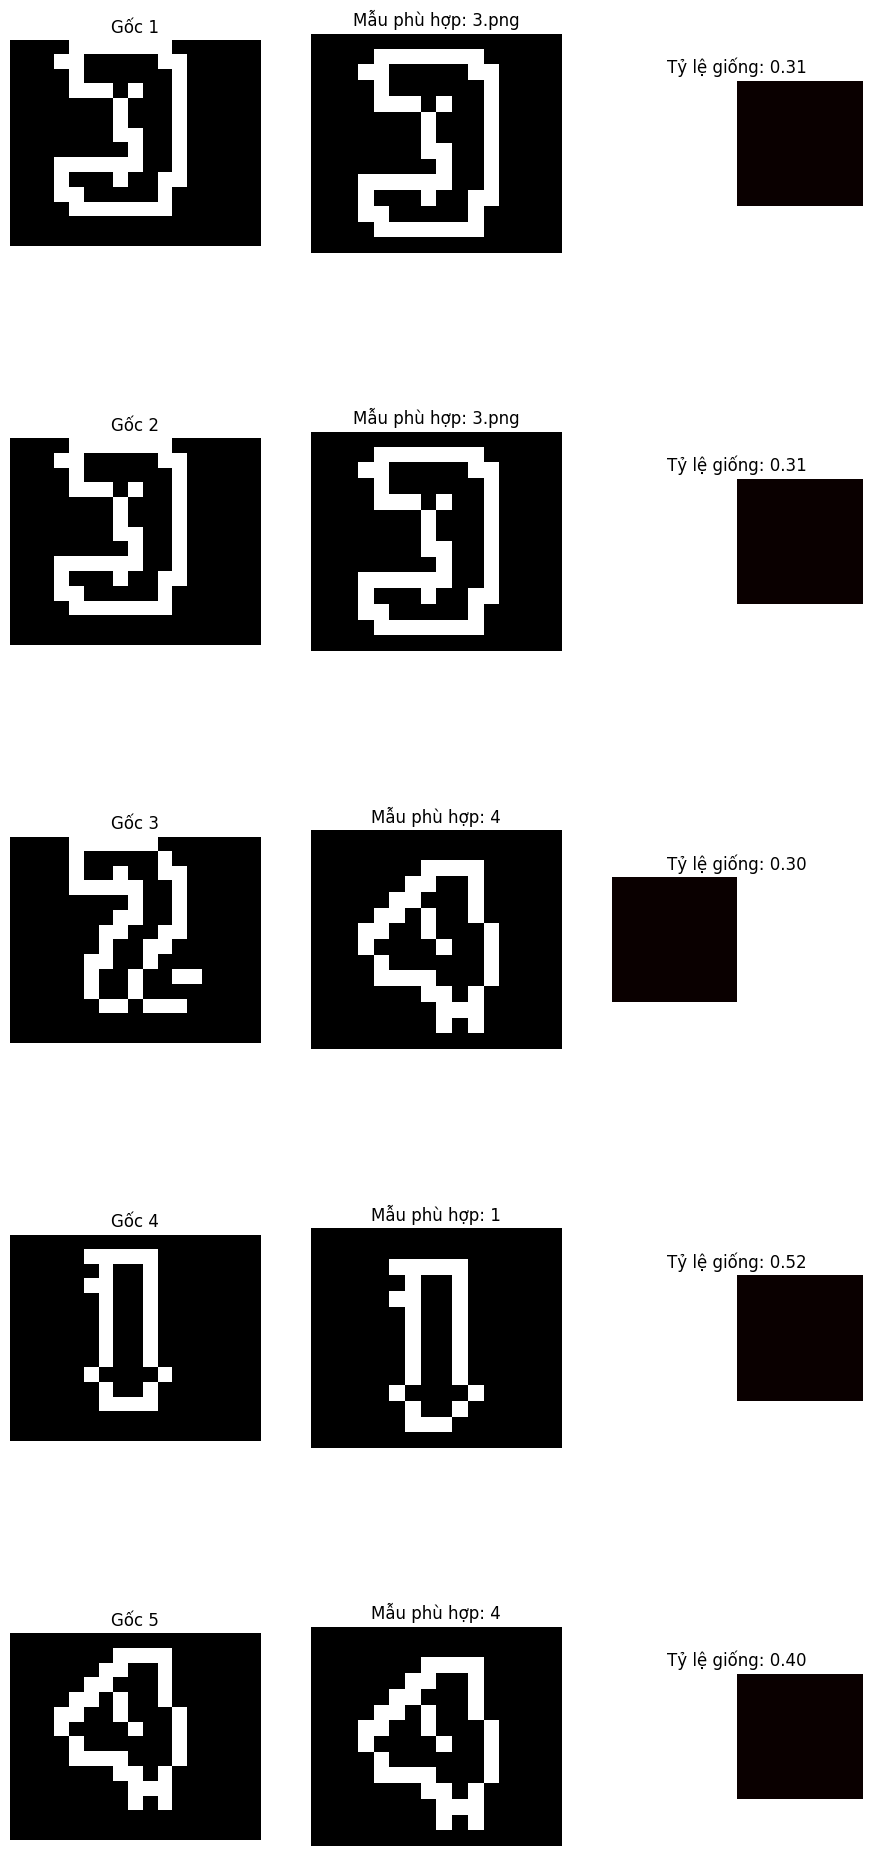

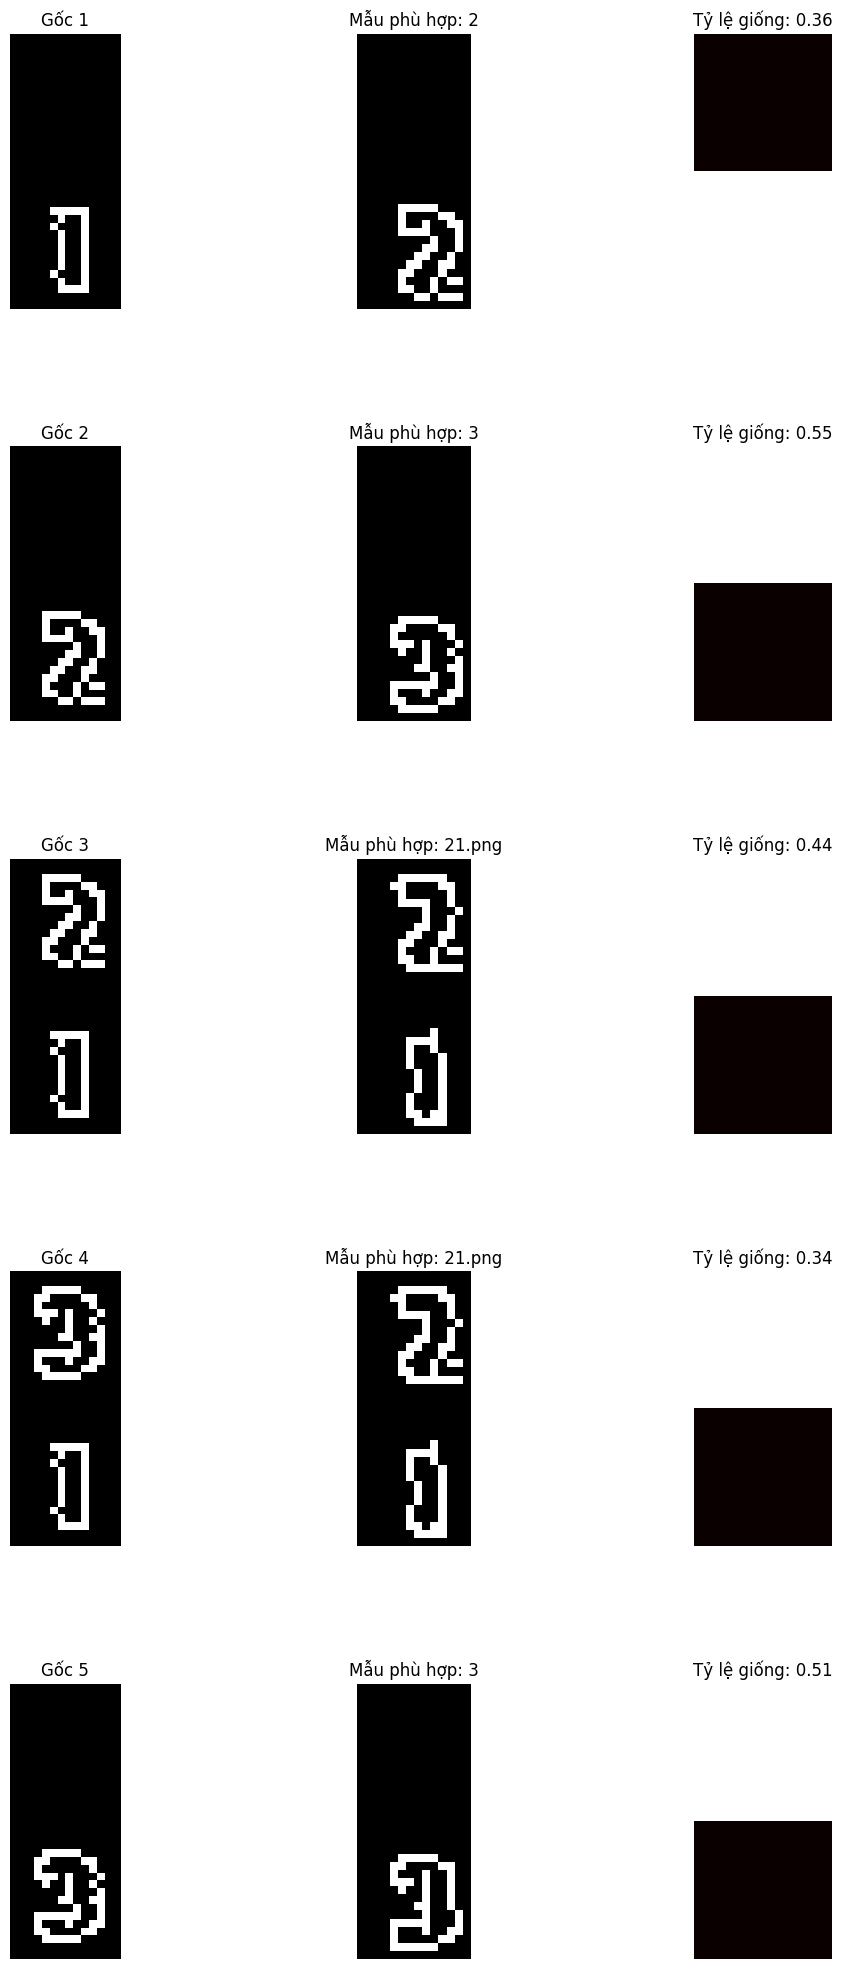

In [ ]:
# Define the path to the sample images directories
column_sample_dir = '/content/drive/MyDrive/2_XLA/Column_samples'
row_sample_dir = '/content/drive/MyDrive/2_XLA/Row_samples'

# Function to perform template matching and find the best match
def find_best_template_match(cell_image, sample_dir, size_threshold=10):
    best_match_score, best_value, best_match_image = -1, None, None

    for sample_filename in os.listdir(sample_dir):
        sample_path = os.path.join(sample_dir, sample_filename)
        sample_image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

        if sample_image.shape[0] > cell_image.shape[0] or sample_image.shape[1] > cell_image.shape[1]:
            continue

        size_diff = abs(cell_image.shape[0] - sample_image.shape[0]) + abs(cell_image.shape[1] - sample_image.shape[1])
        if size_diff > size_threshold:
            continue

        res = cv2.matchTemplate(cell_image, sample_image, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)

        if max_val > best_match_score:
            best_match_score = max_val
            best_value = sample_filename.split(' ')[0]
            best_match_image = sample_image

    return best_value, best_match_image, best_match_score

# Function to split concatenated values into lists of integers
def parse_concatenated_values(value):
    return [int(char) for char in value if char.isdigit()]

# Define a function to crop image margins
def crop_margins(image, top, bottom, left, right):
    return image[top:-bottom, left:-right]

# Initialize the lists to store the column and row values
col_values, row_values = [], []

# Create figures to display the comparisons
fig_row, axes_row = plt.subplots(nrows=len(row_cells), ncols=3, figsize=(11, len(row_cells) * 5))
fig_col, axes_col = plt.subplots(nrows=len(column_cells), ncols=3, figsize=(12, len(column_cells) * 5))

def process_cells(cells, sample_dir, crop_margins_values, axes, values_list):
    for i, cell in enumerate(cells):
        cropped_cell = crop_margins(cell, *crop_margins_values)
        best_match_value, best_match_image, best_match_score = find_best_template_match(cropped_cell, sample_dir)
        if best_match_value:
            values_list.append(parse_concatenated_values(best_match_value))

        axes[i, 0].imshow(cropped_cell, cmap='gray')
        axes[i, 0].set_title(f'Gốc {i+1}')
        axes[i, 0].axis('off')

        if best_match_image is not None:
            axes[i, 1].imshow(best_match_image, cmap='gray')
            axes[i, 1].set_title(f'Mẫu phù hợp: {best_match_value}')
            axes[i, 1].axis('off')

            res = cv2.matchTemplate(cropped_cell, best_match_image, cv2.TM_CCOEFF_NORMED)
            axes[i, 2].imshow(res, cmap='hot')
            axes[i, 2].set_title(f'Tỷ lệ giống: {best_match_score:.2f}')
            axes[i, 2].axis('off')
        else:
            axes[i, 1].set_title('Không mẫu nào giống!')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')

process_cells(row_cells, row_sample_dir, (4, 2, 6, 4), axes_row, row_values)
process_cells(column_cells, column_sample_dir, (6, 4, 3, 3), axes_col, col_values)

# Display the row and column values
print("Row values:", row_values)
print("Column values:", col_values)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()
